In [2]:
#!pip install tensorflow
import tensorflow as tf
import pickle
from pandas import read_csv


In [3]:
print("Loading data...")
training_file = './Data/train.p'

sign_names = read_csv("./Data/signname.csv").values[:, 1]

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
images_train, labels_train = train['features'], train['labels']

for i in range(len(labels_train)):
    # replace hardik with shardul
    if labels_train[i] < 9:
        labels_train[i] = 0
    elif labels_train[i] >= 9:
        labels_train[i] = 1

Loading data...


In [4]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

# Assuming your image dimensions and channels
height = 32  # example height
width = 32   # example width
channels = 3  # RGB channels

def f1_metric(y_true, y_pred):
    return tf.py_function(f1_score, (y_true, y_pred > 0.5), tf.float64)

# Define the new model
model = Sequential([
    # First Convolutional Layer with 32 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, channels)),
    
    # MaxPooling to downsample the output of the first Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer with 64 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    
    # MaxPooling to downsample the output of the second Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer with 128 filters, a 3x3 kernel size, 'same' padding, and ReLU activation
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    
    # MaxPooling to downsample the output of the third Convolutional Layer
    MaxPooling2D((2, 2)),
    
    # Additional Dropout layer after the third Convolutional Layer
    Dropout(0.3),  

    # Flatten layer to convert the 2D output of the convolutional layers into a 1D array
    Flatten(),
    
    # First Dense (fully connected) layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    
    # Dropout layer with 50% dropout rate for regularization
    Dropout(0.5),
    
    # Second Dense layer with 64 units and ReLU activation
    Dense(64, activation='relu'),
    
    # Output layer for binary classification using sigmoid activation
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Finished building model...")

Finished building model...


In [5]:
validation_file = './Data/valid.p'

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
images_valid, labels_valid = valid['features'], valid['labels']

for i in range(len(labels_valid)):
    if labels_valid[i] < 9:
        labels_valid[i] = 0
    elif labels_valid[i] >= 9:
        labels_valid[i] = 1

In [6]:
# model.fit(images_train, labels_train, epochs=10, validation_data=(images_valid, labels_valid))
history = model.fit(images_train, labels_train, epochs=1, validation_data=(images_valid, labels_valid))

1088/1088 [==============================] - 19s 17ms/step - loss: 0.2311 - accuracy: 0.9243 - val_loss: 0.0297 - val_accuracy: 0.9912


In [7]:
# Define the file name for saving the model
model_filename = 'Convolution_Model_Saved'

# Save the model to a file
model.save(model_filename)

INFO:tensorflow:Assets written to: Convolution_Model_Saved/assets


INFO:tensorflow:Assets written to: Convolution_Model_Saved/assets


In [8]:
test_file = './Data/test.p'

with open(test_file, mode='rb') as f:
    test = pickle.load(f)
images_test, labels_test = test['features'], test['labels']

for i in range(len(labels_test)):
 
    # replace hardik with shardul
    if labels_test[i] < 9:
        labels_test[i] = 0
    elif labels_test[i] >= 9:
        labels_test[i] = 1

In [9]:
test_loss, test_accuracy  = model.evaluate(images_test, labels_test)

395/395 [==============================] - 2s 5ms/step - loss: 0.0723 - accuracy: 0.9815


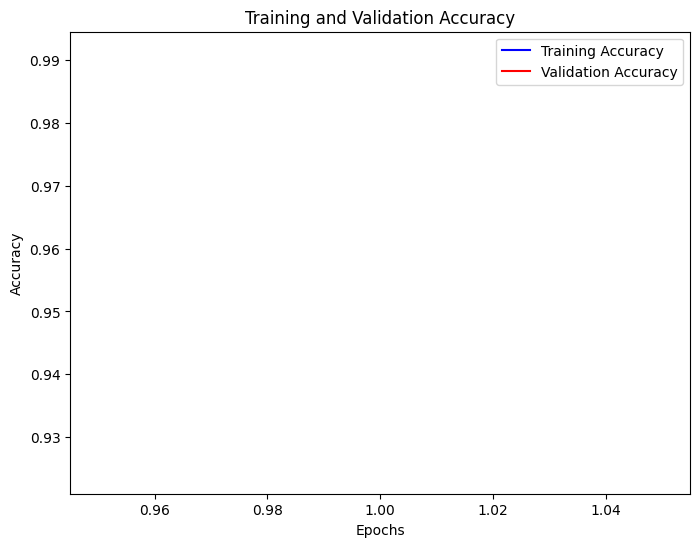

In [10]:
import matplotlib.pyplot as plt
 
# Extract accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
 
# Plot accuracy
fig = plt.figure(figsize=(8, 6))
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
fig.savefig('binary_cnn.png', dpi=fig.dpi)

In [11]:
import tensorflow as tf
from sklearn.metrics import f1_score
import numpy as np

def f1_metric(y_true, y_pred):
    return tf.py_function(f1_score, (y_true, y_pred > 0.5), tf.float64)

# Define your grid search parameters
filter_options = [[32, 64, 128], [64, 128, 256]]  # Example: two sets of filters
dropout_options = [0.3, 0.5]  # Example: two dropout rates

best_accuracy = 0
best_params = {}

for filters in filter_options:
    for dropout_rate in dropout_options:
        model = Sequential([
            Conv2D(filters[0], (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(filters[1], (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(filters[2], (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),
            Dropout(dropout_rate),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_metric])

        # Assuming images_train, labels_train, images_valid, labels_valid are already defined
        history = model.fit(images_train, labels_train, epochs=8, validation_data=(images_valid, labels_valid))

        val_accuracy = np.max(history.history['val_accuracy'])
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = {'filters': filters, 'dropout_rate': dropout_rate}

print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Hyperparameters: {best_params}")

# 1 Epoch
# Best Validation Accuracy: 0.9947845935821533
# Best Hyperparameters: {'filters': [64, 128, 256], 'dropout_rate': 0.3}

# 8 epochs
#Best Validation Accuracy: 0.9997732639312744
#Best Hyperparameters: {'filters': [64, 128, 256], 'dropout_rate': 0.3}

Epoch 1/8
1086/1088 [============================>.] - ETA: 0s - loss: 0.2703 - accuracy: 0.9147 - f1_metric: 0.9375

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 17ms/step - loss: 0.2700 - accuracy: 0.9147 - f1_metric: 0.9376 - val_loss: 0.0462 - val_accuracy: 0.9859 - val_f1_metric: 0.7272
Epoch 2/8
   7/1088 [..............................] - ETA: 20s - loss: 0.0566 - accuracy: 0.9821 - f1_metric: 0.9877

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


1087/1088 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9867 - f1_metric: 0.9898

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0464 - accuracy: 0.9866 - f1_metric: 0.9898 - val_loss: 0.0210 - val_accuracy: 0.9955 - val_f1_metric: 0.7299
Epoch 3/8
   7/1088 [..............................] - ETA: 18s - loss: 0.0609 - accuracy: 0.9821 - f1_metric: 0.9859

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1085/1088 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9908 - f1_metric: 0.9929

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 16ms/step - loss: 0.0316 - accuracy: 0.9908 - f1_metric: 0.9929 - val_loss: 0.0172 - val_accuracy: 0.9952 - val_f1_metric: 0.7298
Epoch 4/8
   8/1088 [..............................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9922 - f1_metric: 0.9943

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0232 - accuracy: 0.9936 - f1_metric: 0.9950

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0232 - accuracy: 0.9936 - f1_metric: 0.9950 - val_loss: 0.0323 - val_accuracy: 0.9909 - val_f1_metric: 0.7268
Epoch 5/8
   4/1088 [..............................] - ETA: 20s - loss: 0.0302 - accuracy: 0.9922 - f1_metric: 0.9942

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0269 - accuracy: 0.9931 - f1_metric: 0.9947

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 18ms/step - loss: 0.0269 - accuracy: 0.9931 - f1_metric: 0.9947 - val_loss: 0.0141 - val_accuracy: 0.9966 - val_f1_metric: 0.7308
Epoch 6/8
   8/1088 [..............................] - ETA: 17s - loss: 0.0220 - accuracy: 0.9883 - f1_metric: 0.9918

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9952 - f1_metric: 0.9963

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0208 - accuracy: 0.9952 - f1_metric: 0.9964 - val_loss: 0.0085 - val_accuracy: 0.9980 - val_f1_metric: 0.7311
Epoch 7/8
   8/1088 [..............................] - ETA: 17s - loss: 7.4050e-04 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0180 - accuracy: 0.9950 - f1_metric: 0.9962

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 18ms/step - loss: 0.0179 - accuracy: 0.9950 - f1_metric: 0.9962 - val_loss: 0.0294 - val_accuracy: 0.9950 - val_f1_metric: 0.7310
Epoch 8/8
   4/1088 [..............................] - ETA: 18s - loss: 0.0512 - accuracy: 0.9844 - f1_metric: 0.9891

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9950 - f1_metric: 0.9962

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0217 - accuracy: 0.9950 - f1_metric: 0.9962 - val_loss: 0.0061 - val_accuracy: 0.9993 - val_f1_metric: 0.7316


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

Epoch 1/8
1087/1088 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.8963 - f1_metric: 0.9253

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 20s 17ms/step - loss: 0.2920 - accuracy: 0.8963 - f1_metric: 0.9254 - val_loss: 0.0778 - val_accuracy: 0.9676 - val_f1_metric: 0.7090
Epoch 2/8
   4/1088 [..............................] - ETA: 20s - loss: 0.1479 - accuracy: 0.9609 - f1_metric: 0.9701

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0571 - accuracy: 0.9823 - f1_metric: 0.9863

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 17ms/step - loss: 0.0573 - accuracy: 0.9823 - f1_metric: 0.9863 - val_loss: 0.0162 - val_accuracy: 0.9959 - val_f1_metric: 0.7314
Epoch 3/8
   4/1088 [..............................] - ETA: 20s - loss: 0.0240 - accuracy: 0.9844 - f1_metric: 0.9895

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9865 - f1_metric: 0.9896

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0440 - accuracy: 0.9865 - f1_metric: 0.9896 - val_loss: 0.0161 - val_accuracy: 0.9975 - val_f1_metric: 0.7309
Epoch 4/8
   4/1088 [..............................] - ETA: 20s - loss: 0.0260 - accuracy: 0.9922 - f1_metric: 0.9939

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9880 - f1_metric: 0.9908

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 16ms/step - loss: 0.0408 - accuracy: 0.9880 - f1_metric: 0.9908 - val_loss: 0.0150 - val_accuracy: 0.9957 - val_f1_metric: 0.7294
Epoch 5/8
   4/1088 [..............................] - ETA: 19s - loss: 0.0216 - accuracy: 0.9922 - f1_metric: 0.9936

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9928 - f1_metric: 0.9945

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0260 - accuracy: 0.9928 - f1_metric: 0.9945 - val_loss: 0.0056 - val_accuracy: 0.9982 - val_f1_metric: 0.7313
Epoch 6/8
   4/1088 [..............................] - ETA: 19s - loss: 0.0117 - accuracy: 0.9922 - f1_metric: 0.9942    

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0285 - accuracy: 0.9916 - f1_metric: 0.9935

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0286 - accuracy: 0.9916 - f1_metric: 0.9935 - val_loss: 0.0226 - val_accuracy: 0.9918 - val_f1_metric: 0.7279
Epoch 7/8
   8/1088 [..............................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9961 - f1_metric: 0.9966

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1086/1088 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9935 - f1_metric: 0.9950

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 18s 17ms/step - loss: 0.0240 - accuracy: 0.9934 - f1_metric: 0.9950 - val_loss: 0.0083 - val_accuracy: 0.9971 - val_f1_metric: 0.7305
Epoch 8/8
   4/1088 [..............................] - ETA: 18s - loss: 0.0058 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1085/1088 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9941 - f1_metric: 0.9954

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 19s 17ms/step - loss: 0.0197 - accuracy: 0.9941 - f1_metric: 0.9954 - val_loss: 0.0032 - val_accuracy: 0.9993 - val_f1_metric: 0.7317
Epoch 1/8


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9152 - f1_metric: 0.9387

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 44s 40ms/step - loss: 0.2558 - accuracy: 0.9153 - f1_metric: 0.9388 - val_loss: 0.0526 - val_accuracy: 0.9844 - val_f1_metric: 0.7247
Epoch 2/8
1088/1088 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9825 - f1_metric: 0.9866

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 43s 40ms/step - loss: 0.0623 - accuracy: 0.9825 - f1_metric: 0.9866 - val_loss: 0.0235 - val_accuracy: 0.9918 - val_f1_metric: 0.7302
Epoch 3/8
1087/1088 [============================>.] - ETA: 0s - loss: 0.0336 - accuracy: 0.9899 - f1_metric: 0.9922

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 45s 41ms/step - loss: 0.0336 - accuracy: 0.9899 - f1_metric: 0.9922 - val_loss: 0.0136 - val_accuracy: 0.9964 - val_f1_metric: 0.7302
Epoch 4/8
1088/1088 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9921 - f1_metric: 0.9940

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 44s 41ms/step - loss: 0.0291 - accuracy: 0.9921 - f1_metric: 0.9940 - val_loss: 0.0263 - val_accuracy: 0.9912 - val_f1_metric: 0.7291
Epoch 5/8
   1/1088 [..............................] - ETA: 43s - loss: 0.0178 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9922 - f1_metric: 0.9941

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 46s 42ms/step - loss: 0.0269 - accuracy: 0.9922 - f1_metric: 0.9941 - val_loss: 0.0044 - val_accuracy: 0.9991 - val_f1_metric: 0.7317
Epoch 6/8
1088/1088 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.9937 - f1_metric: 0.9951

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 47s 43ms/step - loss: 0.0230 - accuracy: 0.9937 - f1_metric: 0.9951 - val_loss: 0.0089 - val_accuracy: 0.9982 - val_f1_metric: 0.7315
Epoch 7/8
   1/1088 [..............................] - ETA: 58s - loss: 0.0183 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9950 - f1_metric: 0.9961

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 44s 40ms/step - loss: 0.0181 - accuracy: 0.9950 - f1_metric: 0.9961 - val_loss: 0.0037 - val_accuracy: 0.9998 - val_f1_metric: 0.7319
Epoch 8/8
   1/1088 [..............................] - ETA: 47s - loss: 0.0032 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9963 - f1_metric: 0.9971

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 46s 42ms/step - loss: 0.0155 - accuracy: 0.9963 - f1_metric: 0.9971 - val_loss: 0.0030 - val_accuracy: 0.9995 - val_f1_metric: 0.7319


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

Epoch 1/8
1087/1088 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.9067 - f1_metric: 0.9313

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 44s 40ms/step - loss: 0.2916 - accuracy: 0.9067 - f1_metric: 0.9314 - val_loss: 0.0145 - val_accuracy: 0.9982 - val_f1_metric: 0.7315
Epoch 2/8
   1/1088 [..............................] - ETA: 42s - loss: 0.0761 - accuracy: 0.9688 - f1_metric: 0.9767

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9812 - f1_metric: 0.9856

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 42s 38ms/step - loss: 0.0616 - accuracy: 0.9812 - f1_metric: 0.9856 - val_loss: 0.0129 - val_accuracy: 0.9966 - val_f1_metric: 0.7299
Epoch 3/8
   1/1088 [..............................] - ETA: 41s - loss: 0.1975 - accuracy: 0.9375 - f1_metric: 0.9444

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0404 - accuracy: 0.9880 - f1_metric: 0.9908

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 42s 39ms/step - loss: 0.0405 - accuracy: 0.9880 - f1_metric: 0.9907 - val_loss: 0.0371 - val_accuracy: 0.9889 - val_f1_metric: 0.7286
Epoch 4/8
   1/1088 [..............................] - ETA: 39s - loss: 3.8907e-04 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9879 - f1_metric: 0.9907

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 41s 38ms/step - loss: 0.0415 - accuracy: 0.9879 - f1_metric: 0.9907 - val_loss: 0.0146 - val_accuracy: 0.9950 - val_f1_metric: 0.7297
Epoch 5/8
   1/1088 [..............................] - ETA: 39s - loss: 9.0390e-04 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.9930 - f1_metric: 0.9947

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 41s 38ms/step - loss: 0.0274 - accuracy: 0.9929 - f1_metric: 0.9946 - val_loss: 0.0105 - val_accuracy: 0.9989 - val_f1_metric: 0.7317
Epoch 6/8
   1/1088 [..............................] - ETA: 41s - loss: 0.0241 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1087/1088 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9935 - f1_metric: 0.9950

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 42s 39ms/step - loss: 0.0227 - accuracy: 0.9935 - f1_metric: 0.9950 - val_loss: 0.0086 - val_accuracy: 0.9973 - val_f1_metric: 0.7308
Epoch 7/8
   1/1088 [..............................] - ETA: 40s - loss: 0.0123 - accuracy: 1.0000 - f1_metric: 1.0000

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9935 - f1_metric: 0.9949

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 43s 39ms/step - loss: 0.0258 - accuracy: 0.9935 - f1_metric: 0.9949 - val_loss: 0.0084 - val_accuracy: 0.9977 - val_f1_metric: 0.7312
Epoch 8/8
1088/1088 [==============================] - ETA: 0s - loss: 0.0196 - accuracy: 0.9948 - f1_metric: 0.9959

/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z

1088/1088 [==============================] - 42s 38ms/step - loss: 0.0196 - accuracy: 0.9948 - f1_metric: 0.9959 - val_loss: 0.0056 - val_accuracy: 0.9982 - val_f1_metric: 0.7318
Best Validation Accuracy: 0.9997732639312744
Best Hyperparameters: {'filters': [64, 128, 256], 'dropout_rate': 0.3}


/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/jonasbrockmoller/Documents/GitHub/Traffic-Sign-Recognition/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `z